In [80]:
import requests
import json
import pandas as pd
import time
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Functions

In [4]:
def extract_data(data, device_num, start_date, end_date, parameter):
    column_name = f'{device_num}_{parameter}'
    columns_to_select = ['UTC time', column_name]
    data_for_device = data[columns_to_select]
    data_for_device = data_for_device[data_for_device['UTC time'] >= start_date]
    data_for_device = data_for_device[data_for_device['UTC time'] <= end_date]
    return data_for_device

## Read airly data from 2018

In [57]:
locations = pd.read_csv("data/location_const.csv")
locations = locations[['id', 'latitude', 'longitude', 'city', 'street', 'number','elevation']]
locations = locations.set_index('id', drop = False)
airly_data_2018 = pd.read_csv("data/data.csv")

start_date = "2018-10-23T00:00:00"
end_date = "2018-11-23T23:00:00"
parameter = 'pm25'
for loc in locations['id']:
    try:
        data = extract_data(airly_data_2018, loc, start_date, end_date, parameter)
        change = data[f'{loc}_{parameter}']
        locations.loc[loc, 'values'] = ','.join(list(map(lambda x: str(x), change)))
    except KeyError:
        locations = locations.drop(index=loc)
        continue
locations

,id,latitude,longitude,city,street,number,elevation,values
id,,,,,,,,
820,820,50.052433,19.949579,Kraków,Starowiślna,79a,207.02,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na..."
1081,1081,50.055163,19.947015,Kraków,Starowiślna,38,207.89,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na..."
622,622,50.044424,19.952205,Kraków,Krakusa,11,205.57,"12.63,12.7,15.86,18.88,23.66,29.35,24.09,17.02..."
842,842,50.042480,19.944330,Kraków,Kalwaryjska,30,204.47,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na..."
2277,2277,50.056538,19.954229,Kraków,Prochowa,1,203.75,"11.41,10.51,14.97,18.23,21.48,25.77,23.09,15.2..."
201,201,50.054907,19.956501,Kraków,Masarska,9,203.13,"10.06,10.09,12.97,15.2,19.71,23.64,21.75,14.42..."
1026,1026,50.038499,19.946850,Kraków,Krzemionki,30,240.90,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na..."
2701,2701,50.056919,19.929686,Kraków,Felicjanek,18,208.45,"12.29,12.63,14.84,19.2,21.69,27.18,24.42,17.8,..."
204,204,50.062006,19.940984,Kraków,Mikołajska,4B,220.38,"9.41,8.7,11.93,13.11,16.84,23.01,21.29,14.32,1..."


## Prepare triangulation with average values for each triangle

In [58]:
def get_avg_data_for_triangle(triangle, values):
    values_for_triangle = list(np.array(values)[triangle])
    values_for_triangle = [x.split(',') for x in values_for_triangle]
    return [np.nanmean(np.array(x).astype(np.float))for x in list(zip(*values_for_triangle))]

In [59]:
points = [[float(x), float(y)] for x,y in zip(list(locations['longitude']), list(locations['latitude']))]
points = np.array(points)
tri = Delaunay(points)
triangles = tri.simplices

values = list(locations['values'])
avg = []
for triangle in triangles:
    avg.append(get_avg_data_for_triangle(triangle, values))
print(avg)


/home/oswin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


[[15.73, 12.93, 26.96, 53.65, 23.9, 25.67, 26.7, 19.59, 15.05, 17.49, 20.76, 18.0, 19.06, 19.61, 19.79, 23.74, 30.05, 27.8, 17.54, 9.82, 6.12, 5.86, 11.25, 9.29, 6.48, 1.91, 1.2, 1.37, 0.93, 1.74, 1.77, 2.05, 1.75, 1.28, 0.65, 0.64, 0.59, 0.88, 2.7, 6.02, 6.98, 7.99, 7.71, 6.87, 7.9, 7.17, 14.53, 17.92, 8.84, 7.04, 11.77, 15.486666666666666, 8.9, 9.303333333333333, 12.093333333333334, 14.726666666666667, 15.756666666666666, 13.719999999999999, 14.386666666666665, 10.32, 8.083333333333334, 8.35, 10.1, 12.613333333333335, 23.889999999999997, 24.973333333333333, 36.93666666666667, 41.03666666666667, 41.76, 44.199999999999996, 46.48, 44.949999999999996, 41.156666666666666, 37.449999999999996, 33.29666666666667, 28.30333333333333, 25.396666666666665, 26.133333333333336, 34.49333333333333, 30.473333333333333, 32.93666666666667, 29.073333333333334, 28.72666666666667, 28.296666666666667, 26.893333333333334, 24.340000000000003, 24.69333333333333, 29.366666666666664, 31.38, 36.49333333333333, 43

## Create correlation matrix

In [16]:
from scipy.cluster.hierarchy import linkage
from  scipy.cluster.hierarchy import fcluster
corr_matrix = np.nan_to_num(np.corrcoef(avg))
dissimilarity = 1 - np.abs(corr_matrix)
hierarchy = linkage(dissimilarity, method='average')
labels = fcluster(hierarchy, 0.5, criterion='distance')
print(labels)


[ 7  3  1  1  1 23 22  1  1 22 22  1 10 10 31  1  1  1  1  1  1  1 26 22
 23 23 22 23  1  3  1 21  1  1 10 15 15  1  1  1 30 14 14  1 22 22  1  1
  1  2  1  1  1 21  2  2 26 21  9 10 10  1 13 13  1  1 21 21  1  1  1  1
  1  1  1  1  1 28 22 22 23  1  1  1  6  1  1  1 22 13  1 26 26 26  1  1
  1  1  1  2 26  9  9 10  1 26 26  2  3  3  1  1 13  1  1  1  1 11 25 25
  2 26 25  1 10  1  1  1  1  1  1  1 27  1 22 23  1 14  1  1  1 19 24 10
  9  1 10 10 10  1  1  1  1  3  3  1  3 20 20 20 20  1 19 19 20 13 13 16
 13  1  1 14  1 14  1  1  7  1  1  1  1 29 29  7  9  9 10 18 18  1  1  1
  1  1  1  1  8  1  1  1  1  1  1 18 19 18 19 19 20 13 13 20 13  1 12 13
 13 20 13 16 13 16 16 16  1  1  1  1  1  1  1  1  1  1  1  1  8  7  1  9
 10  9 10  9 10  9  5 33  8  8  5 35  5 34 35  1  1  1  1 20 18  9  9 18
 20 13 13 20 20 20 20 20  4  4  4 34  1  1  1  1  1  1  1  1  1  1 32  1
  1  1 32  1  7  8 32  7 32  1  8  4  1 34  1  1  1  1 33 35 18  1  1  1
  1 17 17  1 17 18 20 18 20 19 19 20 20 20 20 20 20

## Plot 

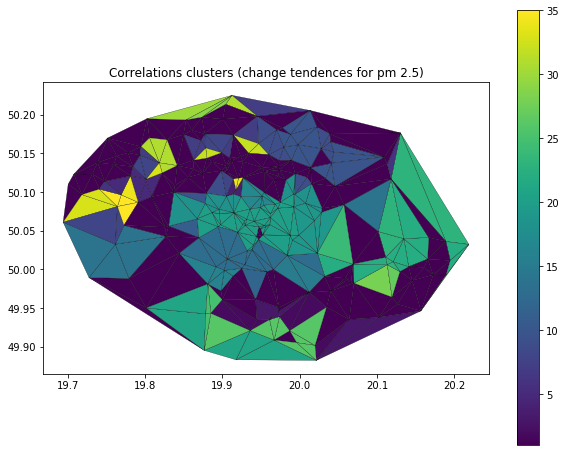

In [81]:
x = points[:,0]
y = points[:,1]
triang = mtri.Triangulation(x, y, triangles)

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, facecolors=labels, edgecolors='k')
fig1.colorbar(tpc)
plt.title("Correlations clusters (change tendences for pm 2.5)")
plt.show()
# plt.savefig('data/triangulation.png')

In [46]:
labels.shape

(408,)

In [66]:
avg_avg = np.array([ np.mean(row)  for row in np.nan_to_num(avg)])

In [67]:
avg_avg

array([19.89860175, 17.90151685, 21.18395755, 23.83682896, 22.59810861,
       21.73170412, 22.37838951, 21.8336392 , 21.35775905, 24.21578027,
       24.76785268, 18.82980025, 21.72259051, 20.45536829, 20.46405743,
       17.84130462, 22.69721598, 21.54469413, 21.3319226 , 20.17940075,
       17.59044944, 19.7476779 , 18.64475655, 21.70031835, 22.91499376,
       22.52274657, 24.02901998, 22.25470037, 23.46289014, 18.43162297,
       19.55626717, 25.22071785, 18.36751561, 17.37073658, 22.09250936,
       20.33155431, 18.72863296, 28.86177278, 32.12289638, 15.18342072,
       17.23898252, 29.41470037, 27.5372784 , 18.4131211 , 23.5239201 ,
       23.73015605, 20.17659176, 23.9775593 , 23.94817104, 20.49656679,
       20.22390137, 19.67563046, 18.13957553, 23.92470662, 17.70421348,
       16.797603  , 20.18624844, 23.25535581, 19.72179775, 21.47453184,
       23.39064295, 16.85062422, 17.9056367 , 18.58315855, 27.26612984,
       22.92042447, 24.50826467, 23.53443196, 18.0889201 , 17.95

## Plot avarage pm 2.5 value per region

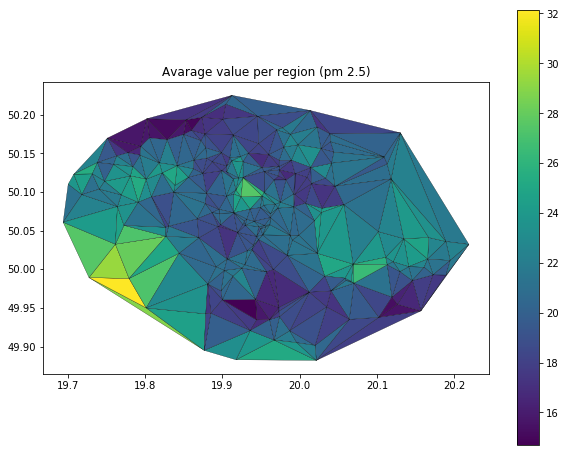

In [82]:
x = points[:,0]
y = points[:,1]
triang = mtri.Triangulation(x, y, triangles)

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, facecolors=avg_avg, edgecolors='k')
fig1.colorbar(tpc)
plt.title("Avarage value per region (pm 2.5)")
plt.show()

## Plot worst value per region

In [75]:
worst = np.array([max(row) for row in np.nan_to_num(avg)])
worst = np.nan_to_num(worst)

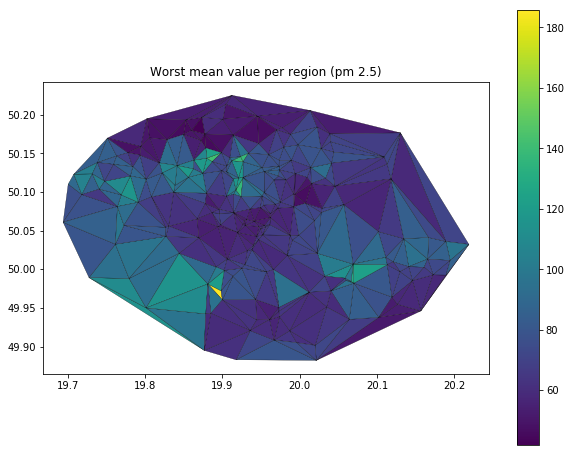

In [83]:
x = points[:,0]
y = points[:,1]
triang = mtri.Triangulation(x, y, triangles)

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, facecolors=worst, edgecolors='k')
fig1.colorbar(tpc)
plt.title("Worst mean value per region (pm 2.5)")
plt.show()

Hello
